# Predicting the Survival of Titanic Passengers

### By Thomas Bierly

#### With data from the kaggle.com “Titanic: Machine Learning from Disaster” Competition

The RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after it collided with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard the ship, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

![H.M.S. Titanic](Titanic1.jpeg "H.M.S. Titanic")

## Machine learning process
![Process](process.png "Process")

## Import Libraries

In [39]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import mitosheet
import lux
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# OS tweaks for my computer
import os
os.environ['NUMEXPR_MAX_THREADS'] = '20'

## Import Dataset

In [107]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [108]:
train_df.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [109]:
train_df.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [110]:
train_df.head(8)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [111]:
mitosheet.sheet(train_df)

MitoWidget(analysis_data_json='{"analysisName": "UUID-d068e719-0ec9-4612-9d9d-5e8e0cd6324b", "code": {"imports…

#### Missing values?

In [112]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

#### What values are important?

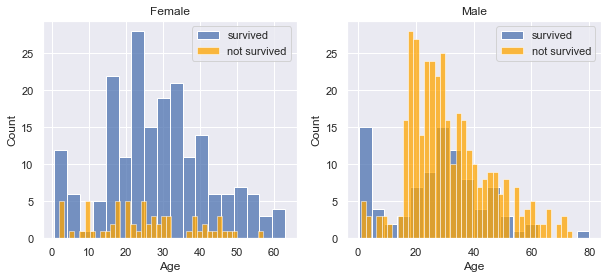

In [113]:
survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

ax = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.histplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color = "orange")
ax.legend()
ax.set_title('Female')

ax = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.histplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color = "orange")
ax.legend()
_ = ax.set_title('Male')

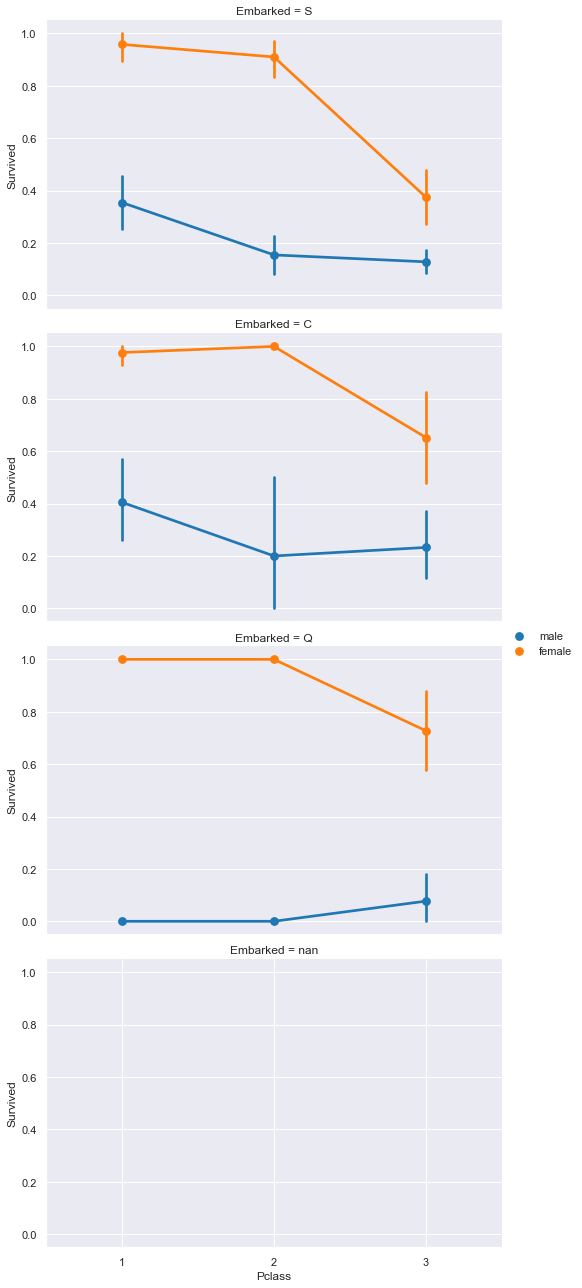

In [114]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette="tab10",  order=None, hue_order=None )
FacetGrid.add_legend()

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

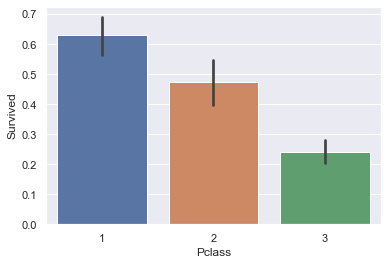

In [115]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

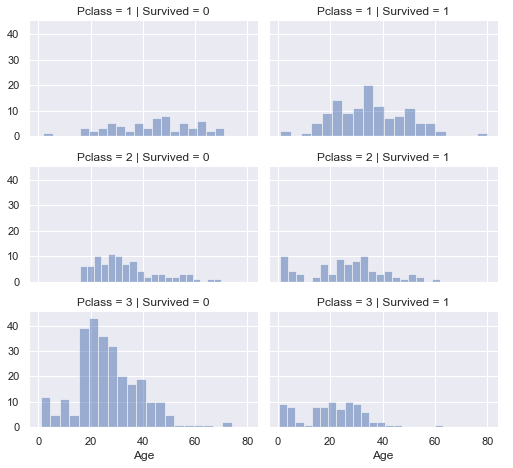

In [116]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [117]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

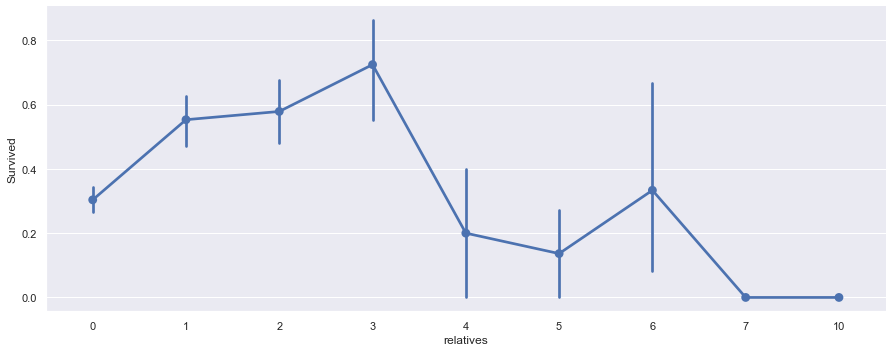

In [118]:
axes = sns.catplot(x = 'relatives', y = 'Survived', 
                      data=train_df, aspect = 2.5, kind = "point")

## Data Cleaning

In [119]:
# Drop ID as this doesn't help prediction
train_df = train_df.drop(['PassengerId'], axis=1)

#### Identify Cabin and Deck

![Titanic Cabins](Titanic2.png "Titanic Cabins")

In [120]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

#### Fill in missing values

##### Ages

In [121]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

##### Embarked

In [122]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object


In [123]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [124]:
train_df.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int32  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int32  
 12  Deck       891 non-null    int32  
dtypes: float64(1), int32(3), int64(5), object(4)
memory usage: 80.2+ KB


#### Create Categories

##### Fare

In [125]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

##### Name

In [126]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

##### Gender

In [127]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

##### Ticket - Too many to categorise so it will be dropped

In [128]:
train_df['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object


In [129]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

##### Embarked

In [130]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

##### Age Categories

In [131]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

##### Fare

In [132]:
train_df.head(10)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [133]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

## Feature Engineering

#### Age x Class

In [134]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### Fare per Person

In [135]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [136]:
train_df.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [137]:
train_df.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Survived         891 non-null    int64
 1   Pclass           891 non-null    int64
 2   Sex              891 non-null    int64
 3   Age              891 non-null    int32
 4   SibSp            891 non-null    int64
 5   Parch            891 non-null    int64
 6   Fare             891 non-null    int32
 7   Embarked         891 non-null    int64
 8   relatives        891 non-null    int64
 9   not_alone        891 non-null    int32
 10  Deck             891 non-null    int32
 11  Title            891 non-null    int64
 12  Age_Class        891 non-null    int64
 13  Fare_Per_Person  891 non-null    int32
dtypes: int32(5), int64(9)
memory usage: 80.2 KB


## Write Cleaned Data to CSV

In [138]:
test_df.to_csv("test_clean.csv")
train_df.to_csv("train_clean.csv")

## Train Learning Algorithm Models

In [143]:
# X_train are the predictive features
X_train = train_df.drop("Survived", axis=1)

#Y_train is the outcome
Y_train = train_df["Survived"]

X_test  = test_df.drop("PassengerId", axis=1).copy()

#### Stochastic Gradient Descent (SGD):

In [144]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

#### Random Forest:

In [145]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

#### Logistic Regression:

In [147]:
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

#### K Nearest Neighbor:

In [148]:
# KNN 
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

#### Gaussian Naive Bayes:

In [150]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

#### Perceptron:

In [153]:
perceptron = Perceptron(max_iter=50)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

#### Linear Support Vector Machine:

In [165]:
linear_svc = LinearSVC(dual=False)
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

#### Decision Tree

In [164]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  

Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

## Score Models

In [166]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

##### Random Forest K-Fold Cross Validation:

In [167]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.78888889 0.84269663 0.75280899 0.82022472 0.84269663 0.85393258
 0.82022472 0.76404494 0.86516854 0.84269663]
Mean: 0.819338327091136
Standard Deviation: 0.0365325232875263


## Random Forest Evaluation
![Random Forest](randomforest.png "Random Forest")

In [169]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

<AxesSubplot:xlabel='feature'>

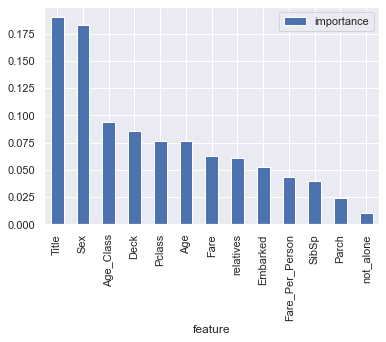

In [171]:
importances.plot.bar()

##### Drop not_alone and Parch

In [172]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

In [221]:
test_df.head()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [222]:
train_df.head()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [223]:
test_df.to_csv("test_clean.csv", index=False)
train_df.to_csv("train_clean.csv", index=False)

#### Train Random Forest Again

In [187]:
# X_train are the predictive features
X_train = train_df.drop("Survived", axis=1)

#Y_train is the outcome
Y_train = train_df["Survived"]

X_test  = test_df.drop("PassengerId", axis=1).copy()

# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.7 %


C:\Users\Thomas\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [188]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 81.71000000000001 %


#### Tune Hyperparamaters

In [ ]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, Y_train)
clf.best_params_

In [211]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 83.28 %


C:\Users\Thomas\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:X does not have valid feature names, but RandomForestClassifier was fitted with feature names


##### Confusion Matrix

In [212]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

C:\Users\Thomas\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:X does not have valid feature names, but RandomForestClassifier was fitted with feature names
C:\Users\Thomas\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:X does not have valid feature names, but RandomForestClassifier was fitted with feature names
C:\Users\Thomas\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[494,  55],
       [ 88, 254]], dtype=int64)

##### Precision Recall

In [213]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.8220064724919094
Recall: 0.7426900584795322


##### F-Score

In [214]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.7803379416282642

##### Precision Recall Curve

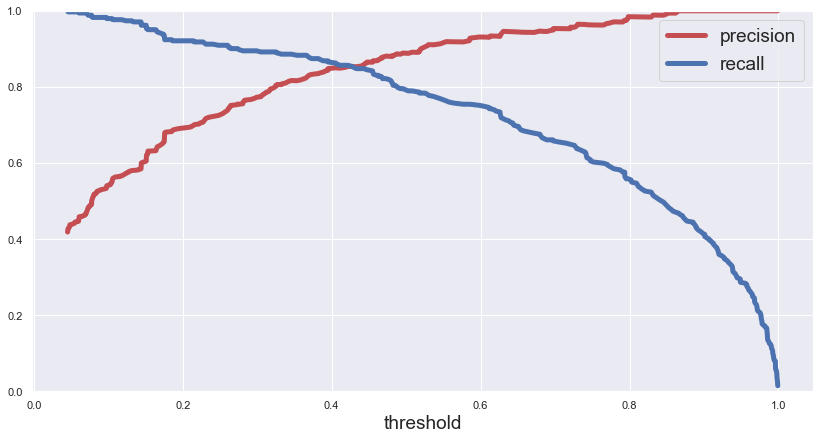

In [215]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

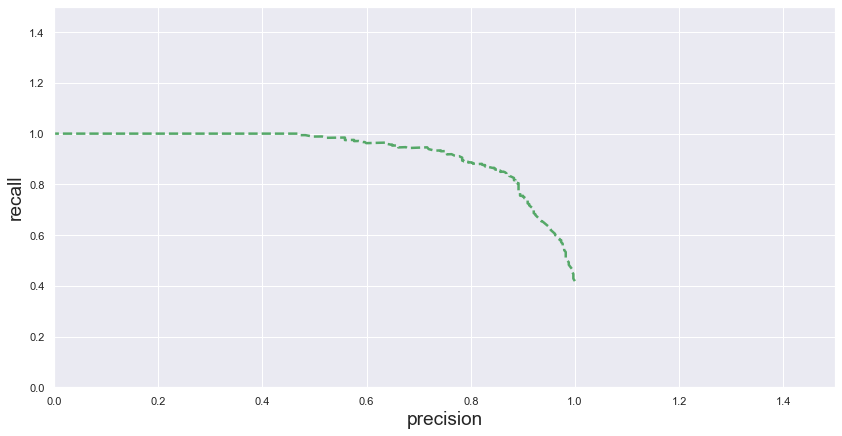

In [216]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

##### ROC AUC Curve

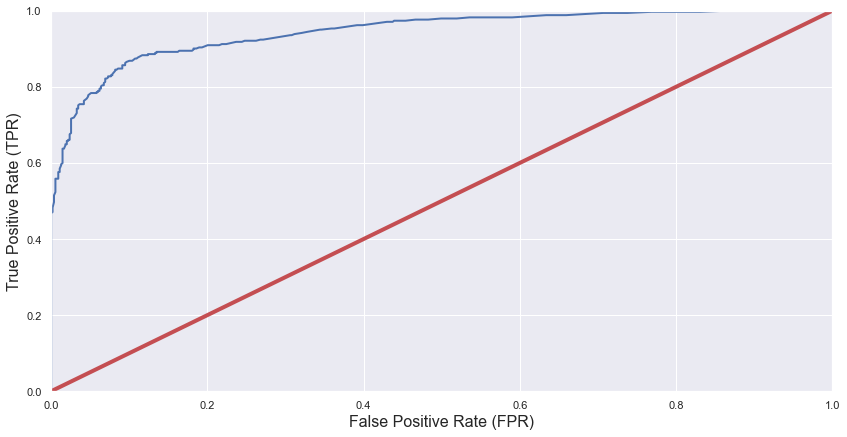

In [217]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [218]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9443885213945611
